## Image processing tools
Install python libraries `Pillow` and `scikit-image` first.
References:
[PIL Image](https://pillow.readthedocs.io/en/3.1.x/reference/Image.html)
[scikit-image](http://scikit-image.org/docs/stable/)

In [1]:
import numpy as np
import json
from matplotlib import (pyplot as plt, patches as patches)
from PIL import Image # pip install pillow
from skimage.filters import threshold_local # pip install scikit-image

### Image processing utilities

In [2]:
# area of bounding box
def rotate_bbox_area(img, deg):
    box = img.rotate(deg, expand=True).getbbox()
    return (box[3] - box[1]) * (box[2] - box[0])
    
def rotate_crop(img, deg, padding=0):
    img_rotate = img.rotate(deg, expand=True, resample=Image.BILINEAR)
    box = img_rotate.getbbox()
    if padding > 0:
        box = np.asarray(box) + [-padding, -padding, +padding, +padding]
    return img_rotate.crop(box)


tol_deg = 10
# smallest bounding box wihin -10~10 degrees rotation
def opt_rotate(img, padding=0):
    opt_deg = np.argmin(
        [rotate_bbox_area(img, i) for i in range(-tol_deg,tol_deg+1)]
        ) - tol_deg
    return rotate_crop(img, opt_deg, padding)

# downsampling
def img_reduce(img, side=28, mode=Image.ANTIALIAS):
    h = side + 1 
    w = int(side * img.width / img.height) + 1
    img_reduced = img.copy()
    # the reduced image size is (w-1, h-1)
    img_reduced.thumbnail((w, h), mode)
    return img_reduced


# convert PIL.Image object to numpy.Array, for training
def img2arr(img):
    return np.asarray(img.getdata(), dtype=np.uint8).reshape(img.height, img.width, -1)


# convert binarized image to gray-scale image with alpha channel
def bin2LA(bin_img):
    mask = np.uint8(255 * (False == bin_img))
    box = Image.fromarray(mask).getbbox()
    LA_img = np.concatenate((np.uint8(255 * bin_img)[:,:,None], mask[:,:,None]), axis=2)
    LA_img = Image.fromarray(LA_img).convert('LA')
    return LA_img.crop(box)


# process single signature with transparent background
def process_one(img):
    return img_reduce(opt_rotate(img, padding=1).convert('LA'))

# binarize images using adaptive thresholding
def binarize(raw_img, block_size, offset):
    r = 255. / raw_img.max()
    raw_img *= r
    bin_adapt = (raw_img > threshold_local(raw_img, block_size=block_size, offset=offset))
    return bin2LA(bin_adapt)


# process multiple signatures in photos
def process_multiple(raw_img, n_rows=1, n_cols=1, block_size=75, offset=70):
    # !!adjust **block_size** and **offset** to achieve the best result!!
    # **block_size** sets the local area to adapt the threshold
    # larger **offset** filters out more noise (but may neglect some strokes)
    bin_img = binarize(raw_img, block_size, offset)
    # plot before cuttings into individual signatures
    # plt.imshow(bin_img, cmap='gray_r')
    # plt.show()
    #bin_img.save('bin_all.png')

    # assuming multiple signatures are equally-spaced, n_rows, n_cols
    fig, ax = plt.subplots(n_rows, n_cols)
    step_w, step_h = bin_img.size / np.array([n_cols*1., n_rows*1.])
    res = np.zeros((n_rows, n_cols), dtype=np.object)
    # expand the cutting area with some tolerance length
    tol = 2
    for i in range(n_rows):
        for j in range(n_cols):
            left, top = step_w*j, step_h * i
            box = np.int64(np.round([left-tol, top-tol, left + step_w + tol, top + step_h + tol]))
            # find best orientation and crop the signature
            res[i, j] = opt_rotate(bin_img.crop(box), padding=1)
            plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
            #plt.imshow(res[i,j]) # plot before downsampling
            res[i,j] = img_reduce(res[i,j])
            plt.imshow(res[i,j]) # plot after downsampling
            #res[i,j].save(f'bin-r{i+1}-c{j+1}.png')
    plt.show()
    return res, bin_img



Compare to digits in MNIST dataset, the signature has larger width/height ratio. One trick is only to train SVM on a specific square region in the bounding box of the signature. You can also explore other methods to use the entire signature without training too many model parameters.

In [3]:
# draw sliding squares with half of side overlap
def draw_sliding_sq(img, ax):
    box = img.getbbox()
    print('bbox', box)

    w, h = box[2]-box[0], box[3] - box[1]
    r = w * 2. / h
    # number of sliding squares, may miss small portions of the signautre on the two ends
    n_box = int(np.round(r+0.1)) - 1

    left = int((box[0] + box[2]) / 2. - h * (1 + n_box) / 4.) - 1
    top = int( (box[1]+box[3] - h) / 2. ) - 1

    ax.imshow(img, cmap='gray_r')
    for i in range(n_box):
        left_i = left + (i*h)//2
        # the square retion can be obtained by
        # img_sq = img.crop((left_i, top, left_i + h, top + h))
        
        ax.add_patch(
            patches.Rectangle((left_i, top), h, h,
                            linewidth=1, edgecolor='r', facecolor='none')
        )

    #plt.show()

### Examples

image size (255, 127)
bbox (8, 42, 185, 113)
reduced to (76, 28)


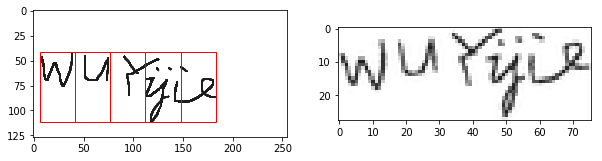

In [4]:
# processing signatures collected through web canvas, with transparent background
image_file = 'canvas.png'
img = Image.open(image_file).convert('LA')
print('image size', img.size)

plt.subplots(1,2, figsize=(10,5))
ax = plt.subplot(1,2,1)
draw_sliding_sq(img, ax)

ax = plt.subplot(1,2,2)
img_reduced = process_one(img)
print('reduced to', img_reduced.size)
plt.imshow(img_reduced)
plt.show()
img_reduced.save('normalized_signature.png')

image size (256, 128)
bbox (8, 42, 186, 113)
reduced to (76, 28)


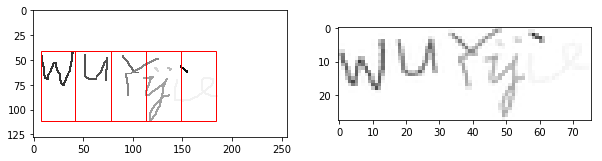

In [5]:
# This section is for online Signature Verification (**not required**)
stroke_file = 'canvas.json'
strokes = [np.asarray(i).reshape((-1,2)) for i in json.load(open(stroke_file,'r'))]
stroke_img = np.zeros((128,256,2), dtype=np.uint8) # gray-scale with alpha channel

# later stroke use lighter color (optional)
# color value between (0.1 ~ 0.95) * 255
step = 1./(len(strokes) - 1)
i = 0.
for s in strokes:
    i += step
    for (x,y) in s:
        # stroke width 2
        stroke_img[y-1:y+1, 
                   x-1:x+1, 
                   :] = [int(np.round(255 * (0.1 + 0.85 * i))), 255]
    
stroke_img = Image.fromarray(stroke_img).convert('LA')
print('image size', stroke_img.size)

plt.subplots(1,2, figsize=(10,5))
ax = plt.subplot(1,2,1)
draw_sliding_sq(stroke_img, ax)

plt.subplot(1,2,2)
stroke_img_reduced = process_one(stroke_img)
print('reduced to', stroke_img_reduced.size)
plt.imshow(stroke_img_reduced)
plt.show()
stroke_img_reduced.save('normalized_stroke.png')

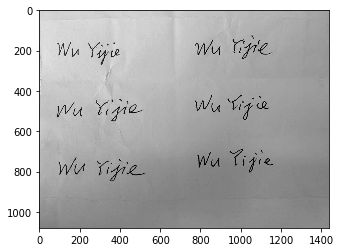

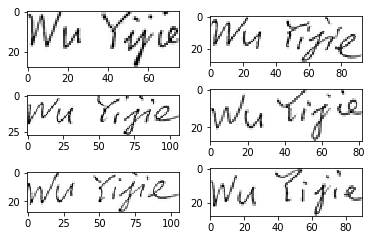

In [6]:
# processing multiple signatures in real photos taken through mobile camera
raw_img = plt.imread('photo.jpeg').mean(axis=2) # 2-D np.Array
plt.subplots(1)
plt.imshow(raw_img, cmap='gray')
plt.show()
bin_img, signatures = process_multiple(raw_img, n_rows=3, n_cols=2)

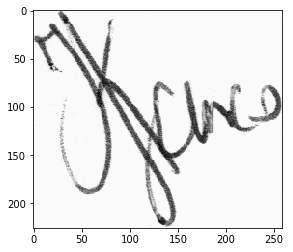

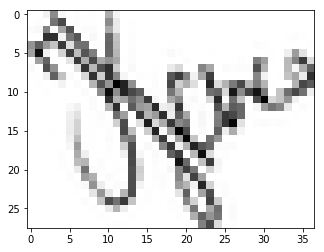

In [7]:
# another photo containing one single signature, but the background is not transparent
raw_img = plt.imread('photo.png').mean(axis=2) # 2-D np.Array
plt.subplots(1)
plt.imshow(raw_img, cmap='gray')
plt.show()
# experiment to find the best block_size and offset!!
#bin_img = binarize(raw_img, 75, 15)
#plt.imshow(bin_img, cmap='gray')
#plt.show()
signatures, bin_img = process_multiple(raw_img, offset=15)
signatures[0,0].save('normalized_photo.png')

### Convert to matrices for training

In [8]:
# the matrix data for training
img_arr = img2arr(img_reduced)[:,:,0] # ignore the alpha channel
print(img_arr.shape, img_arr.dtype)

(28, 76) uint8


You will probably need some data augmentation to fully utilize limited amount of data, like:
- slightly rotating round the best orientation, 
- slightly changing the width/height ratio, 
- slightly scaling-down and translating the normalized signature, and probably 
- add some random noisy points. 

See references at the begining to perform such augmentation